In [140]:
from garminconnect import Garmin
from Garmin import keys

API = Garmin(keys.JVPA.User, keys.JVPA.pss)
API.login()

True

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
PATH = '/Volumes/web/Python/Garmin/'
bins = [41, 119, 149, 158, 165, 200]
names = [ 'Z1', 'Z2', 'Z3', 'Z4', 'Z5']

In [131]:
def decode(dat):
    volume = 0
    if dat is not None:
        for i in dat:
            volume += i['volume'] /1e3
        
    return volume

columns= ['activityId', 'activityName','duration','calories','bmrCalories', 'movingDuration'
          ,'averageHR','trainingEffectLabel','activityTrainingLoad', 'summarizedExerciseSets']
z = API.get_activities_by_date(pd.read_pickle(f'{PATH}fitness_equipment.pkl').index.max().isoformat()
                               , datetime.now().isoformat(), 'fitness_equipment')
                                                
actividades = dict([(pd.to_datetime(k['startTimeLocal'])
                     , list((k[i] if i != 'summarizedExerciseSets' 
                                else decode(None if 'summarizedExerciseSets' not in k else k[i]
                                        )) for i in columns))
                   for k in z])

df = (pd.DataFrame.from_dict(actividades, orient = 'index', columns = columns) 
               .assign(duration = lambda x: x.duration.astype(int)
                       , summarizedExerciseSets= lambda x: x.summarizedExerciseSets.astype(int)
                       , calories = lambda x: x.calories.astype(int)
                       , bmrCalories = lambda x: x.bmrCalories.astype(int)
                       , averageHR = lambda x: x.averageHR.astype(int)
                       , activityTrainingLoad = lambda x: round(x.activityTrainingLoad,2)
                       , movingDuration = lambda x: x.movingDuration.astype(int))
               .sort_index()
              .rename(columns={'summarizedExerciseSets':'Volumen'
                               , 'movingDuration':'tActivo', 'bmrCalories':'cReposo'})
      .query('activityId != {0}'.format(pd.read_pickle(f'{PATH}fitness_equipment.pkl').activityId.to_list())))

if len(df) > 0:
    GP = pd.DataFrame()
    for k in df.activityId.to_dict():
        GPX = API.get_activity_details(df[df.index == k].activityId[0])
        GP = pd.concat([GP
                        , pd.DataFrame([r['metrics'] for r in GPX['activityDetailMetrics']]
                                       , columns=[i['key'].replace('direct','') for i in GPX['metricDescriptors']])
                        .assign(Seconds = lambda x: x.sumElapsedDuration - x.sumElapsedDuration.shift(1).fillna(0)
                                , Duration = lambda x: x.Seconds.sum()
                                , zones = lambda x: pd.cut(x.HeartRate, bins, labels = names))
                        .groupby(by='zones')
                        .agg({'Seconds':lambda x: x.sum(), 'Duration': lambda x: x.max()})
                        .assign(activityId = df[df.index == k].activityId[0]
                               , Fecha = k
                               , Seconds = lambda x: x.Seconds/x.Duration)
                        .reset_index()
                        .pivot(index = ['Fecha'], columns = 'zones', values = 'Seconds')
                        .fillna(0)])
    
    pd.concat([pd.read_pickle(f'{PATH}fitness_equipment.pkl')
                    , pd.concat([df,GP], axis = 1)
                   ]).sort_index().to_pickle(f'{PATH}fitness_equipment.pkl')

pd.concat([pd.read_pickle(f'{PATH}fitness_equipment.pkl').tail(1)
           , (pd.read_pickle(f'{PATH}fitness_equipment.pkl') 
              .query('activityName == {0}'.format(pd.read_pickle(f'{PATH}fitness_equipment.pkl')
                                                  .tail(1).activityName.to_list()))
              .sort_values(by = ['Volumen'])
              .tail(5))]
         ).drop_duplicates().sort_index()

,activityId,activityName,duration,calories,cReposo,tActivo,averageHR,trainingEffectLabel,activityTrainingLoad,Volumen,Z1,Z2,Z3,Z4,Z5
2024-06-03 06:21:29,15715046829,Sentadillas,3003,294,62,1727,100,AEROBIC_BASE,10.78,13294,0.891211,0.108789,0.000000,0.000000,0.00000
2024-06-14 06:11:01,15901308579,Sentadillas,3137,337,64,1690,107,ANAEROBIC_CAPACITY,101.32,12710,0.693975,0.269366,0.001275,0.004144,0.03124
2024-11-09 06:13:32,17492752661,Sentadillas,4388,468,91,2468,111,AEROBIC_BASE,31.79,15340,0.729945,0.267548,0.000000,0.000000,0.00000
2024-11-18 05:47:05,17564261440,Sentadillas,5237,537,108,2809,107,AEROBIC_BASE,35.15,18080,0.761314,0.235822,0.000000,0.000000,0.00000
2024-11-22 05:54:59,17594647201,Sentadillas,4034,452,83,2379,112,AEROBIC_BASE,41.46,14122,0.724598,0.273671,0.000000,0.000000,0.00000


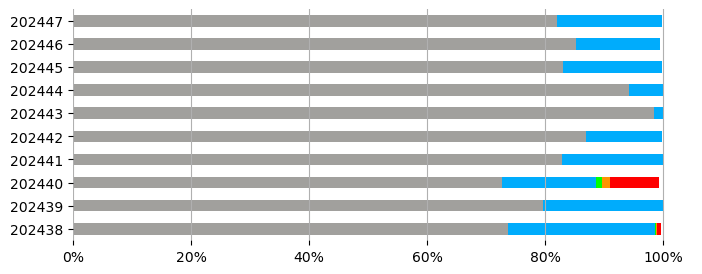

In [132]:
x = (pd.read_pickle(f'{PATH}fitness_equipment.pkl')
 .assign(Zona1 = lambda x:  x.duration * x.Z1
         , Zona2 = lambda x:  x.duration * x.Z2
         , Zona3 = lambda x:  x.duration * x.Z3
         , Zona4 = lambda x:  x.duration * x.Z4
         , Zona5 = lambda x:  x.duration * x.Z5)
 .resample('w')
 .agg({'Zona1':lambda x: x.sum()
       , 'Zona2':lambda x: x.sum()
       , 'Zona3':lambda x: x.sum()
       , 'Zona4':lambda x: x.sum()
       , 'Zona5':lambda x: x.sum()
       , 'Zona5':lambda x: x.sum()
       , 'duration': lambda x: x.sum()})
 .assign(Zona1 = lambda x:  x.Zona1 / x.duration
         , Zona2 = lambda x:  x.Zona2 / x.duration 
         , Zona3 = lambda x:  x.Zona3 / x.duration 
         , Zona4 = lambda x:  x.Zona4 / x.duration 
         , Zona5 = lambda x:  x.Zona5 / x.duration )
 .drop(columns=['duration'])
 .tail(10)
 .plot(figsize = (8, 3)
       , color = ['#a1a09d','#00acfc','#00ff01','#fe9400','#fe0000']
       , kind = 'barh'
       , stacked = True, legend=None))

x.set_yticklabels(
    list((datetime.strptime(i.get_text()[0:10],'%Y-%m-%d').strftime('%Y%W')) 
                                             for i in x.get_yticklabels()))
x.set_xticklabels(['{:,.0f}%'.format(i*100) for i in x.get_xticks()])
[i.set_visible(False) for i in x.spines.values()]
plt.grid(axis = 'x')

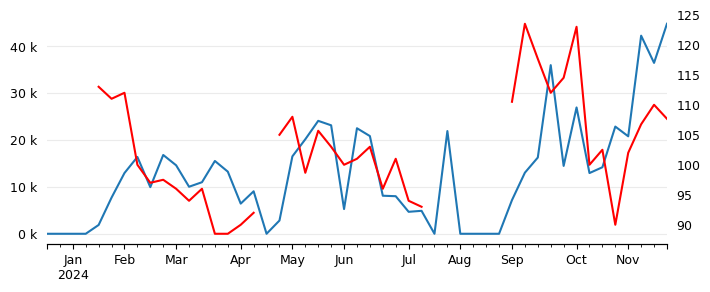

In [133]:
df = (pd.read_pickle(f'{PATH}fitness_equipment.pkl')
      .query('activityName in ["Fuerza - Fisio", "Sentadillas"]')
      .resample('w')
            .agg({'Volumen':lambda x: round(sum(x), 2)
                  , 'averageHR': lambda x: x.mean()})).tail(52)

fig, ax = plt.subplots()
ax = df['Volumen'].plot(figsize = (8, 3))

eje = ax.twinx()
df.averageHR.plot(ax=eje, color="red")

[x.spines[i].set_visible(False) for i in ['top', 'left', 'right'] for x in [eje, ax]]
[x.tick_params(left = False, bottom = True, right = False, labelsize=9) for x in [ax, eje]]
[i.set_yticklabels([str(int(x.get_text()if '−' not in x.get_text() else x.get_text().replace('−', '-'))  / 1e3)
                    [:-2] + ' k' for x in i.get_yticklabels()]) for i in [ax]]

ax.grid(axis = 'y', alpha = .25)

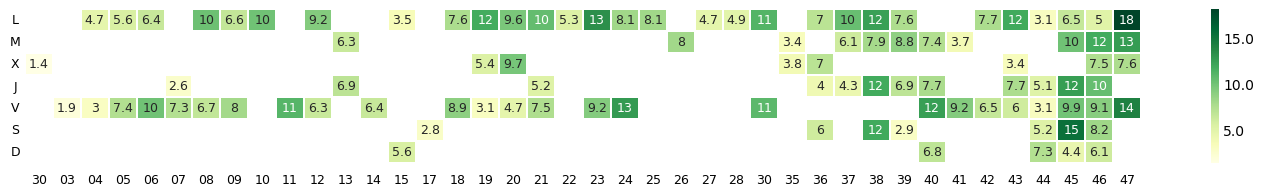

In [134]:
df = (pd.read_pickle(f'{PATH}fitness_equipment.pkl')
      .query('activityName in ["Fuerza - Fisio", "Sentadillas", "Core"]')
      .resample('d')
      .agg({'Volumen':lambda x: sum(x)})
      .assign(Week = lambda x: x.index.strftime('%y%W')
              , WeekDay = lambda x: x.index.strftime('%w')
              , WeekD = lambda x: x.WeekDay.apply(lambda i: '7' if i=='0' else i))
      .query('Volumen>0')
      .groupby([ 'WeekD', 'Week']).Volumen
      .sum()
      .unstack()
      .iloc[:, -42:])

fig = plt.figure(figsize=(18,2))

Grafico = sns.heatmap(df, cmap = 'YlGn', linewidth = 0.1
                      , annot_kws = {"size": 9}
                      , cbar = False
                      , annot = df.apply(lambda x: [round(i/1e3,1) for i in x], axis=0))

bar = Grafico.figure.colorbar(Grafico.collections[0])

Grafico.set_xticklabels([x.get_text()[2:] for x in Grafico.get_xticklabels()], rotation = 0)
Grafico.set_yticklabels(['L','M','X','J','V','S','D'], ha='center', rotation = 0)
Grafico.set(xlabel = None, ylabel= None)
Grafico.tick_params(left = False, bottom = False, labelsize=9)


bar.set_ticklabels(list((x / 1e3) for x in p.get_ticks()))
bar.outline.set_visible(False)
bar.ax.tick_params(size=0)

fig.show()

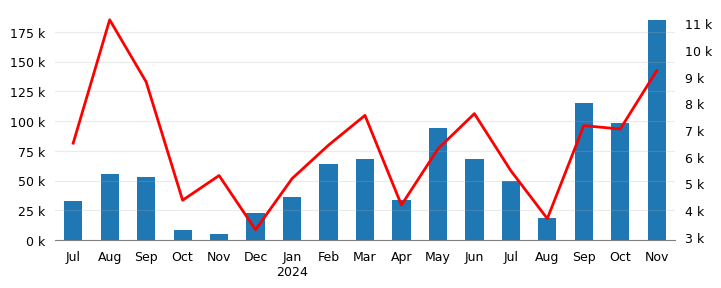

In [135]:
dat = (pd.read_pickle(f'{PATH}fitness_equipment.pkl').Volumen
       .resample('m').agg(['sum','mean'])
       .rename({'sum':'Volumen', 'mean': 'Promedio'}, axis=1)
       .assign(indice = lambda x: x.index.strftime('%b\n%Y')
               , periodo = lambda x: x.indice.apply(lambda i: i if 'Jan' in i else i[:3]))
       .set_index('periodo'))

fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(111)
eje = ax.twinx()

dat.Promedio.plot(kind='line',color='red', ax=eje, lw=2)
dat.Volumen.plot(kind='bar', legend=None, ax= ax)

[i.set_visible(False) for i in ax.spines.values()]
[x.tick_params(left = False, bottom = False, right = False, labelsize=9) for x in [ax, eje]]
[eje.spines[x].set_visible(False) for x in ['top','left','right']]
[i.set_yticklabels([str(int(x.get_text()) / 1e3)[:-2] + ' k' for x in i.get_yticklabels()]) for i in [ax, eje]]
eje.spines['bottom'].set_color('grey')
ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()], rotation = 0)
ax.set_xlabel(None)
ax.grid(axis = 'y', alpha= .25)